In [1]:
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from mcmc import *
import pickle

In [2]:
with open("./data/corpus_wikipedia_2020-03-01_all_lines.txt") as f:
    lines = f.readlines(int(1e8))


In [3]:
full_text = " ".join(lines).lower().replace('!', '.')


In [4]:
len(full_text)


100888469

In [5]:
known_chars = "aąbcćdeęfghijklłmnńoóprsśtuvwxyzżź0123456789 ,."


In [6]:
full_text = remove_unknown_symbols(known_chars, full_text)

In [7]:
text_to_decode = (
    "na fundamentach starego urzędu gminy, rozpoczęto budowę nowego obiektu, mającego w przyszłości spełniać rolę gminnego ośrodka kultury gok."
    " uroczyście otwarty w dniu 23 maja 1989 r. gminny ośrodek kultury, zwany z racji widniejącego na frontonie rzeźby mitycznego pegaza,"
    " pod pegazem, okazał się wyśmienitym obiektem do pełnienia roli do jakiej został powołany."
).lower()

In [59]:
text_lengths = [10**i for i in range(4,8)] +[len(full_text)]

In [60]:
text_lengths

[10000, 100000, 1000000, 10000000, 98777608]

In [86]:
random.seed(123)
hamming_losses_arrays = []
final_texts = []
runs_scores = []
iters = int(1e+5)
num_repeats = 30
num_previous_chars=1
for text_length in text_lengths:
    count_dict = create_count_dict(full_text[:text_length], known_chars)
    perc_dict = create_perc_dict(count_dict, known_chars)

    crypt_keys = create_rand_crypt(known_chars)
    crypt_dict = str_to_key(known_chars, crypt_keys)
    crypt_text = apply_dict(text_to_decode, crypt_dict)
    

    _final_texts = []
    run_scores = []
    hamming_losses_array = []
    for _ in range(num_repeats):
        current_dict, best_score, best_text, hamming_losses, scores = decrypt_MCMC(crypt_text, perc_dict, crypt_keys, known_chars, iters,verbose = False, real_text=text_to_decode, num_previous_chars=num_previous_chars)
        hamming_losses_array.append(hamming_losses)
        _final_texts.append(best_text[-1])
        run_scores.append(np.array(scores))
    hamming_losses_array = np.array(hamming_losses_array)
    final_texts.append(_final_texts)
    hamming_losses_arrays.append(hamming_losses_array)
    runs_scores.append(np.stack(run_scores))

hamming_losses_arrays = np.stack(hamming_losses_arrays)
runs_scores = np.stack(runs_scores)

100%|██████████| 1966/1966 [00:00<00:00, 1352912.50it/s]


In [94]:
with open('evaluations/final_texts_1_word.pkl', 'wb') as f:
    pickle.dump(final_texts, f)

np.save('./evaluations/text_length_tests/hamming_losses.npy', hamming_losses_arrays)
np.save('./evaluations/text_length_tests/scores.npy', runs_scores)

In [99]:
for hamming_losses_array in hamming_losses_arrays:
    print(np.mean(hamming_losses_array[:,-1]))

0.9746296296296297
0.6514814814814814
0.6650925925925928
0.3566666666666667
0.2753703703703704


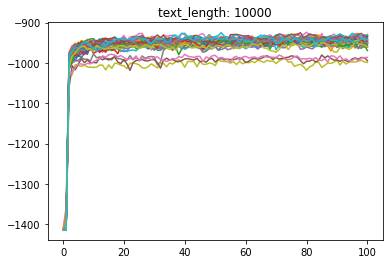

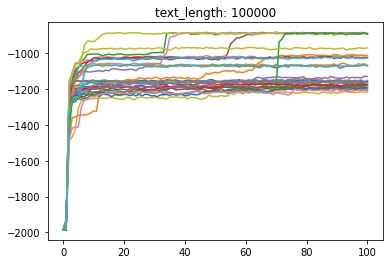

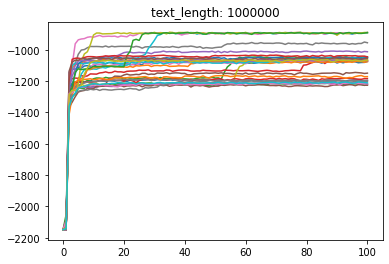

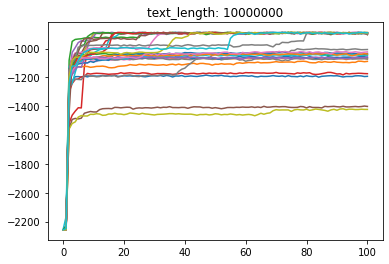

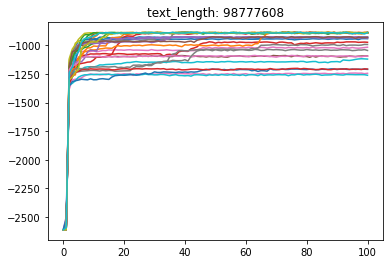

In [89]:
run_num = 0
for run_num in range(len(runs_scores)):
    for i in range(runs_scores[run_num].shape[0]):
        plt.plot(runs_scores[run_num][i])
    plt.title(f'text_length: {text_lengths[run_num]}')
    plt.show()


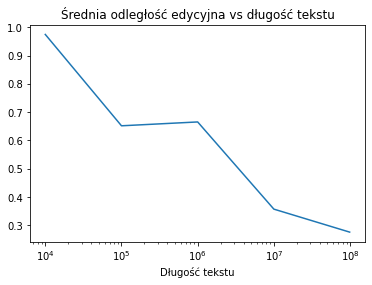

In [100]:
ax = plt.plot(text_lengths, [np.mean(hamming_losses_array[:,-1]) for hamming_losses_array in hamming_losses_arrays])
plt.title('Średnia odległość edycyjna vs długość tekstu')
plt.xscale('log')
plt.xlabel('Długość tekstu')
plt.show()

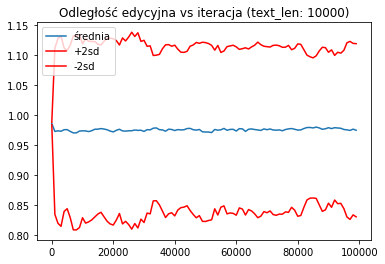

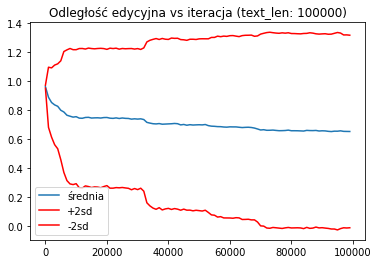

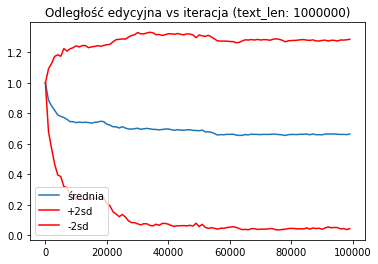

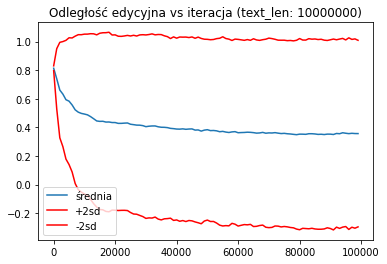

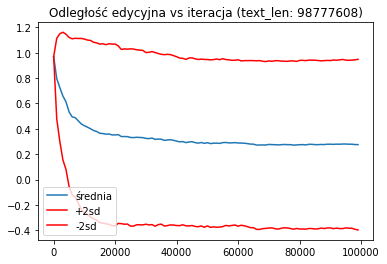

In [101]:
xticks = [1000*i for i in range(len(hamming_losses))]
for i, hamming_losses_array in enumerate(hamming_losses_arrays):
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0))
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)+2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.plot(xticks, np.mean(hamming_losses_array, axis=0)-2*np.sqrt(np.var(hamming_losses_array,axis=0)), c='red')
    plt.title(f'Odległość edycyjna vs iteracja (text_len: {text_lengths[i]})')
    plt.legend(("średnia", "+2sd", "-2sd"))
    plt.show()